# Train classifier for P5 vehicle finding

**Author: olala7846@gmail.com**

## Step 1: observe training data

In [1]:
# first do some training data observation
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random


vehicle_imgs = list(glob.glob('./vehicles/**/*.png'))
nonvehicle_imgs = list(glob.glob('./non-vehicles/**/*.png'))

print('Total %d vehicle images' % len(vehicle_imgs))
print('Total %d non-vehicle images' % len(nonvehicle_imgs))
print('There are about the same size of both classes')

sample_img = random.sample(vehicle_imgs, 1)[0]
img = cv2.imread(sample_img)
print('images has shape', img.shape, 'and dtype', img.dtype)
print('Pixel value range approximately from', np.max(img), 'to', np.min(img))

Total 8792 vehicle images
Total 8968 non-vehicle images
There are about the same size of both classes
images has shape (64, 64, 3) and dtype uint8
Pixel value range approximately from 255 to 6


## Step 2: plot and see how training data distributed on different color spaces

In [2]:
# Explore different color space
from mpl_toolkits.mplot3d import Axes3D

convertors = {
    'RGB': cv2.COLOR_BGR2RGB,
    'HLS': cv2.COLOR_BGR2HLS,
    'YUV': cv2.COLOR_BGR2YUV,
    'YCrCb': cv2.COLOR_BGR2YCrCb,
    'Lab': cv2.COLOR_BGR2Lab,
    'Luv': cv2.COLOR_BGR2Luv,
}

def plot3d(car_pixels, non_car_pixels):
    """Plot pixels in 3D"""
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    all_pixels = np.vstack((car_pixels, non_car_pixels))

    # Set axis limits
    ax.set_xlim(np.min(all_pixels[:, 0]), np.max(all_pixels[:, 0]))
    ax.set_ylim(np.min(all_pixels[:, 1]), np.max(all_pixels[:, 1]))
    ax.set_zlim(np.min(all_pixels[:, 2]), np.max(all_pixels[:, 2]))

    ax.scatter(
        car_pixels[:, 0].ravel(),
        car_pixels[:, 1].ravel(),
        car_pixels[:, 2].ravel(),
        c='g', edgecolors='none')

    ax.scatter(
        non_car_pixels[:, 0].ravel(),
        non_car_pixels[:, 1].ravel(),
        non_car_pixels[:, 2].ravel(),
        c='r', edgecolors='none')
    
    return ax

def observe_colorspace():
    sample_car_imgs = random.sample(vehicle_imgs, 100)
    sample_noncar_imgs = random.sample(nonvehicle_imgs, 100)

    for name, convertor in convertors.items():
        car_pixels = []
        noncar_pixels = []

        samples_per_pic = 10

        for car_img in sample_car_imgs:
            img = cv2.imread(car_img)
            img = cv2.cvtColor(img, convertor)
            pixels = np.reshape(img, (-1, 3))
            sample_pixels = random.sample(list(pixels), samples_per_pic)
            car_pixels.append(sample_pixels)

        for noncar_img in sample_noncar_imgs:
            img = cv2.imread(noncar_img)
            img = cv2.cvtColor(img, convertor)
            pixels = np.reshape(img, (-1, 3))
            sample_pixels = random.sample(list(pixels), samples_per_pic)
            noncar_pixels.append(sample_pixels)

        car_pixels = np.vstack(car_pixels)
        noncar_pixels = np.vstack(noncar_pixels)

        ax = plot3d(car_pixels, noncar_pixels)
        plt.title(name)
       # plot different view points
        for ii in range(0,360,5):
            ax.view_init(elev=10., azim=ii)
            plt.savefig("./color_spaces/%s%d.png" % (name, ii))
        
#observe_colorspace()

## Step3: Feature extraction

reading  ./vehicles/GTI_Far/image0000.png
(96,)


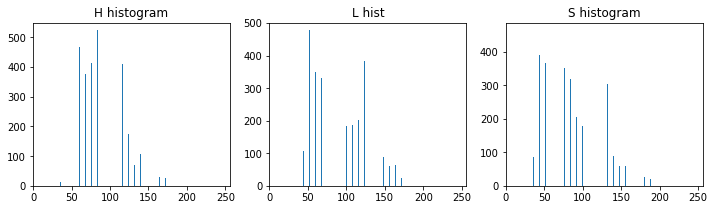

In [3]:
# Extact color histogram features

def color_hist(img, nbins=32, bins_range=(0, 256), visualize=False):
    channel1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    features = np.concatenate((channel1[0], channel2[0], channel3[0]))
    if visualize:
        print(features.shape)
        return features, (channel1, channel2, channel3)
    else:
        return features
    
img_name = vehicle_imgs[0]
print('reading ', img_name)
img = cv2.imread(vehicle_imgs[0])

features, histograms = color_hist(img, visualize=True)
hist1, hist2, hist3 = histograms

# visualize histogram
# calculate bin center
bin_edges = hist1[1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, hist1[0])
plt.xlim(0, 256)
plt.title('H histogram')
plt.subplot(132)
plt.bar(bin_centers, hist2[0])
plt.xlim(0, 256)
plt.title('L hist')
plt.subplot(133)
plt.bar(bin_centers, hist3[0])
plt.xlim(0, 256)
plt.title('S histogram')
plt.show()

In [4]:
# Extract spatial bin features

def bin_spatial(img, size=(32, 32)):
    resize_img = cv2.resize(img, size)
    color1 = resize_img[:,:,0].ravel()
    color2 = resize_img[:,:,1].ravel()
    color3 = resize_img[:,:,2].ravel()
    features = np.hstack((color1, color2, color3))
    return features

img_name = vehicle_imgs[0]
print('reading ', img_name)
img = cv2.imread(vehicle_imgs[0])
features = bin_spatial(img)
print(features.shape)

reading  ./vehicles/GTI_Far/image0000.png
(3072,)


(7, 7, 2, 2, 9)


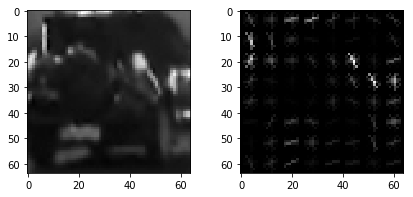

In [5]:
# Extract hog features
from skimage.feature import hog

def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=False):
    return hog(
        img, orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block),
        visualise=vis, feature_vector=feature_vec)


img = cv2.imread(random.sample(vehicle_imgs, 1)[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
features, hog_image = get_hog_features(gray, vis=True)
print(features.shape)
fig = plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.show()

## Step4: Train classifier on features

In [21]:
# Test training on color histogram features
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time

nbins = 128

def extract_features(img, cspace='RGB'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    features = color_hist(cvt_img, nbins=nbins)
    return features

def train_with_color_hist(cspace):
    # extract features
    print(cspace, ':')
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # define labels
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    duration = round(t2-t1, 2)
    accuracy = svc.score(X_test, y_test)
    print('| %s | %.2f | %.4f |' % (cspace, duration, accuracy))

# for key in convertors:
#     train_with_color_hist(cspace=key)

### Result training SVM with color_hist on different color spaces

#### All channel (256 bins) color histogram
| Color space | Time to train | Accuracy | 
|-----|--------|------|
| HLS | 13.46 | 0.9561 |
| RGB | 19.49 | 0.9150 |
| Luv | 12.91 | 0.9271 |
| YCrCb | 14.59 | 0.9414 |
| YUV | 14.76 | 0.9378 |
| Lab | 9.44 | 0.9513 |

#### All channel (128 bins) color histogram
| Color space | Time to train | Accuracy | 
|-----|--------|------|
| HLS | 4.81 | 0.9659 |
| RGB | 8.95 | 0.9223 |
| Luv | 6.57 | 0.9398 |
| YCrCb | 6.89 | 0.9440 |
| YUV | 7.18 | 0.9324 |
| Lab | 4.91 | 0.9513 |


#### All channel (64 bins) color histogram
| Color space | Time to train | Accuracy | 
|-----|--------|------|
| HLS | 5.6200 | 0.96 |
| RGB | 5.9900 | 0.92 |
| Luv | 5.3000 | 0.93 |
| YCrCb | 5.2800 | 0.93 |
| YUV | 5.0400 | 0.92 |
| Lab | 4.8900 | 0.95 |


#### All channel (32 bins) color histogram
| Color space | Time to train | Accuracy | 
|-----|--------|------|
| HLS | 3.2300 | 0.95 |
| RGB | 3.9500 | 0.91 |
| Luv | 4.5800 | 0.91 |
| YCrCb | 6.4900 | 0.92 |
| YUV | 5.0900 | 0.91 |
| Lab | 4.2200 | 0.94 |

#### All channel (16 bins) color histogram
| Color space | Time to train | Accuracy | 
|-----|--------|------|
| HLS | 2.4800 | 0.93 |
| RGB | 2.7300 | 0.89 |
| Luv | 1.9300 | 0.90 |
| YCrCb | 3.6600 | 0.89 |
| YUV | 2.2900 | 0.88 |
| Lab | 2.3000 | 0.90 |


In [22]:
# Test training on bin_spatial features with SVM
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time

size=(16, 16)

def extract_features(img, cspace='RGB'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    features = bin_spatial(cvt_img, size=size)
    return features


def train_with_bin_hist(cspace='RGB'):
    print(cspace, ':')
    # extract features
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # define labels
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    duration = round(t2-t1, 2)
    accuracy = svc.score(X_test, y_test)
    print('| %s | %.2f | %.4f |' % (cspace, duration, accuracy))
    
# for key in convertors:
#     train_with_bin_hist(cspace=key)

### Result training SVM with bin_spatial on different color spaces

#### (32x32) full color channel spatial bin 

| Color space | Time to train | Accuracy | 
|-----|---------|------|
| HLS | 50.7900 | 0.88 |
| RGB | 63.6400 | 0.91 |
| Luv | 48.8200 | 0.89 |
| YCrCb | 44.7200 | 0.91 |
| YUV | 44.1500 | 0.90 |
| Lab | 35.0900 | 0.92 |

#### (16x16) full color channel spatial bin 
It is actually doing better than 32x32 !!!

| Color space | Time to train | Accuracy | 
|-----|---------|------|
| HLS | 21.0200 | 0.91 |
| RGB | 21.8800 | 0.92 |
| Luv | 20.4100 | 0.92 |
| YCrCb | 19.7900 | 0.92 |
| YUV | 19.6800 | 0.91 |
| Lab | 24.8900 | 0.93 |

#### (8x8) full color channel spatial bin 

| Color space | Time to train | Accuracy | 
|-----|---------|------|
| HLS | 8.9500 | 0.87 |
| RGB | 8.2100 | 0.90 |
| Luv | 7.3400 | 0.89 |
| YCrCb | 7.6800 | 0.90 |
| YUV | 7.7800 | 0.90 |
| Lab | 7.0500 | 0.90 |

In [28]:
# Test training on bin_spatial features with SVM
hog_kwargs = {
    'orient': 9,
    'pix_per_cell': 8, 
    'cell_per_block': 3,
}


def extract_features(img, cspace='RGB'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    channel1 = get_hog_features(cvt_img[:,:,0], **hog_kwargs).ravel()
    channel2 = get_hog_features(cvt_img[:,:,1], **hog_kwargs).ravel()
    channel3 = get_hog_features(cvt_img[:,:,2], **hog_kwargs).ravel()

    return np.concatenate((channel1, channel2, channel3))


def train_with_hog_features(cspace='RGB'):
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])

    # define labels
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    duration = round(t2-t1, 2)
    accuracy = svc.score(X_test, y_test)
    print('| %s | %.2f | %.4f |' % (cspace, duration, accuracy))

    
print(hog_kwargs)
for key in convertors:
    train_with_hog_features(cspace=key)

{'orient': 9, 'cell_per_block': 3, 'pix_per_cell': 8}
| HLS | 37.08 | 0.9775 |
| RGB | 42.40 | 0.9724 |
| Luv | 29.24 | 0.9859 |
| YCrCb | 23.50 | 0.9865 |
| YUV | 21.18 | 0.9873 |
| Lab | 33.71 | 0.9851 |


## Some experiment on HOG features

#### All channels pix_per_cell:8  cells_per_block: 2
| Color space | Time to train | Accuracy |
|-------------|----------|---------------|
| HLS | 20.79 | 0.9811 |
| RGB | 27.44 | 0.9682 |
| Luv | 17.99 | 0.9806 |
| YCrCb | 21.87 | 0.9876 |
| YUV | 14.93 | 0.9890 |
| Lab | 16.07 | 0.9848 |

#### All channels pix_per_cell:8  cells_per_block: 1
| Color space | Time to train | Accuracy |
|-------------|----------|---------------|
| HLS | 4.61 | 0.9747 |
| RGB | 6.71 | 0.9459 |
| Luv | 4.40 | 0.9800 |
| YCrCb | 4.16 | 0.9831 |
| YUV | 4.08 | 0.9809 |
| Lab | 4.30 | 0.9809 |

#### {'orient': 9, 'cell_per_block': 3, 'pix_per_cell': 8}
| Color space | Time to train | Accuracy |
|-------------|----------|---------------|
| HLS | 37.08 | 0.9775 |
| RGB | 42.40 | 0.9724 |
| Luv | 29.24 | 0.9859 |
| YCrCb | 23.50 | 0.9865 |
| YUV | 21.18 | 0.9873 |
| Lab | 33.71 | 0.9851 |


## Step 5: Combine all features



In [10]:
# feature selection
from sklearn.feature_selection import SelectFromModel
import time


def extract_features(img, cspace='Luv'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    
    hist_features = color_hist(cvt_img)
    bin_features = bin_spatial(cvt_img)
    channel1 = get_hog_features(cvt_img[:,:,0]).ravel()
    channel2 = get_hog_features(cvt_img[:,:,1]).ravel()
    channel3 = get_hog_features(cvt_img[:,:,2]).ravel()

    return np.concatenate((hist_features, bin_features, channel1, channel2, channel3))


def train_all_features(cspace='RGB'):
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])

    # define features
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # define labels
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()

    duration = round(t2-t1, 2)
    accuracy = svc.score(X_test, y_test)
    print('| %s | %.4f | %.2f |' % (cspace, duration, accuracy))

for key in convertors:
    train_all_features(cspace=key)

(17760, 8460) (17760,)


## Feature selection using devision tree
from 8460 features to 139 features

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

t = time.time()
svc1 = LinearSVC()
svc1.fit(X_train, y_train)
t2 = time.time()
print('Test Accuracy of SVC1 = ', svc1.score(X_test, y_test))
t3 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print(round(t3-t2, 2), 'Seconds to score SVC...')

# tree_clf = DecisionTreeClassifier()
# tree_clf.fit(X_train, y_train)

# print('Feature selection with decision tree')
# feature_select = SelectFromModel(tree_clf, prefit=True)
# X_train_new = feature_select.transform(X_train)
# X_test_new = feature_select.transform(X_test)
# print(X_train.shape)
# print(X_train_new.shape)

# t = time.time()
# svc2 = LinearSVC()
# svc2.fit(X_train_new, y_train)
# t2 = time.time()
# print('Test Accuracy of SVC2 = ', svc2.score(X_test_new, y_test))
# t3 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC2...')
# print(round(t3-t2, 2), 'Seconds to score SVC...')

In [ ]:
import pickle
data = {
#     'feature_select': feature_select,
    'classifier1': svc1,
#     'classifier2': svc2,
    'X_scaler': X_scaler,
}

print(X_scaler)
print(svc1)

filename = 'classifier.pkl'
with open(filename, 'wb') as f:
    pickle.dump(data, f)